# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #9 - Deform a source mesh to form a target mesh using 3D loss functions

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-51diexjz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-51diexjz
  Running command git checkout -q 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 797.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.5-cp310-cp310-linux_x86_64.whl size=56538058 sha256=551ccc2833ef5719af147ad624b29716bf142f52be0278fa5e97dc9434fe4aa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8l37gf_y/wheels/39/5f/20/2d3b6f3a35a60bdc0ba3c19da94340db95966

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [ ]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2023-11-22 23:03:22--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.11, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K  --.-KB/s    in 0.03s   

2023-11-22 23:03:22 (4.61 MB/s) - ‘dolphin.obj’ saved [156763/156763]



In [ ]:
# Load the dolphin mesh.
trg_obj = os.path.join('dolphin.obj')

In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [ ]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

1.1 The source mesh is a sphere of radius 1 centered at (0, 0, 0). To speed up the optimization process, we should scale normalize the target mesh and center it at the origin, making it fit the unit sphere. Do this operations with the `verts`tensor and create a `Meshes` object with the normalized vertices and the faces indices.

1.2 Visualize the source and target meshes using `Plotly` integration.

In [ ]:
##############################################################################
# Code for 1.1 - 1.2
##############################################################################

In [ ]:
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

In [ ]:
fig = plot_scene({
    "subplot1": {
        "src_mesh": src_mesh
    },
    "subplot2": {
        "trg_mesh": trg_mesh
    }

})
fig.show()

###  Visualizing point clouds with Matplotlib

We can also sample points from the surfaces and visualize them using Matplotlib. It can be a useful to have a coarse estimation of the surface during iterations in the optimization process.

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

1.3 Use the function `plot_pointcloud` to see the initial pointcloud

In [ ]:
# %matplotlib inline
##############################################################################
# Code for 1.3
##############################################################################

In [ ]:
plot_pointcloud(src_mesh, "Points over the initial source mesh")

<IPython.core.display.Javascript object>

## 2. Optimization loop

Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize the distance between the predicted (deformed) and target mesh, defined as the **chamfer distance** between the set of pointclouds resulting from **differentiably sampling points** from their surfaces.

However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape. We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:

+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.
We will learn to deform the source mesh by offsetting its vertices

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [ ]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer.detach().cpu().item())
    edge_losses.append(loss_edge.detach().cpu().item())
    normal_losses.append(loss_normal.detach().cpu().item())
    laplacian_losses.append(loss_laplacian.detach().cpu().item())

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


  0%|          | 0/5000 [00:00<?, ?it/s]

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

## Visualize the loss

In [ ]:
def plot_losses(loss_dict, size=(13,5)):
  fig = plt.figure(figsize=size)
  ax = fig.gca()
  for loss_name, loss_values in loss_dict.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [ ]:
losses = {"chamfer loss": torch.cat(chamfer_losses).cpu(),
          "edge loss": torch.cat(edge_losses).cpu(),
          "normal loss": torch.cat(normal_losses).cpu(),
          "laplacian loss": torch.cat(laplacian_losses).cpu()}
plot_losses(losses, (18, 10))

RuntimeError: ignored

## Save the predicted mesh

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

2.1 Scale normalize back the `final_verts` to the original target size



In [ ]:
##############################################################################
# Code for 2.1
##############################################################################

In [ ]:
# just undo the initial operations
final_verts = final_verts * scale + center

In [ ]:
# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

2.2 Visualize the target mesh and the final mesh using `Plotly`. Qualitatively, what do you think of the result?

2.3 Take a look at the **Loss vs Iteration** graph, paying attention to how the losses are decreasing. Do you think it would be possible to achieve a reasonable result with less iterations? Is it worth to run with more iterations? Explain you thoughts, then run the optimization loop again making the changes to validate your hypothesis.

2.4 The loss function used for this task is a linear combination of four losses. Let `w_chamfer = 1.0` and set the other coefficients to zero. Run the  optimization loop again with this configuration and describe the result.

**[EXTRA] E.1 Experiment other coefficients configurations and describe the results.**

2.5 Experiment with others optimizers such as `Adam` and `RMSprop` in place of `SGD`. Also, try changing the learning rate (`lr`), and `momentum` when these parameters are applied. What do you observe in terms of speed of convergence and quality of final results?




In [ ]:
##############################################################################
# Code for 2.1 - 2.5
##############################################################################

In [ ]:
from pytorch3d.io import load_objs_as_meshes

In [ ]:
dolphin_mesh = load_objs_as_meshes([trg_obj], device=device)
final_mesh = Meshes([final_verts], [final_faces])

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning:

No mtl file provided



In [ ]:
fig = plot_scene({
    "subplot1": {
        "src_mesh": dolphin_mesh
    },
    "subplot2": {
        "trg_mesh": final_mesh
    }

})
fig.show()

# 3. Experimenting with Other Shapes

In [ ]:
# download the mug model - Mug by Microsoft is licensed under Creative Commons Attribution
# originally found at https://sketchfab.com/3d-models/mug-17c4808537f1448590378b3643c6da72
!wget https://raw.githubusercontent.com/hallpaz/3dsystems21/main/data/mug.obj

--2023-05-23 09:50:05--  https://raw.githubusercontent.com/hallpaz/3dsystems21/main/data/mug.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525932 (514K) [text/plain]
Saving to: ‘mug.obj’

mug.obj             100%[===================>] 513.61K  --.-KB/s    in 0.006s  

2023-05-23 09:50:06 (77.9 MB/s) - ‘mug.obj’ saved [525932/525932]



3.1 Is it possible to deform any mesh into another? Explain your thoughts.

3.2 Run the experiment again and try to deform a sphere into a mug.

3.3 Change the `src_mesh` to a `torus`. You can import the torus primitive from `pytorch3d.utils`. Now, try to deform the torus into a mug.


**[Extra] E.2 Run the experiments again using other shapes (either find and download shapes from the internet or create your own models).**

In [ ]:
##############################################################################
# Code for 3.1 - 3.3
##############################################################################

In [ ]:
from pytorch3d.utils import torus

In [ ]:
torus_mesh = torus(0.5, 1.0, 50, 90, device=device)

In [ ]:
verts, faces, aux = load_obj("/content/mug.obj")
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

mug_mesh = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)])

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:548: UserWarning:

Mtl file does not exist: /content/Mug.mtl



In [ ]:
fig = plot_scene({
    "torus": {
        "src_mesh": torus_mesh
    },
    "mug": {
        "trg_mesh": mug_mesh
    }

})
fig.show()

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(torus_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = torus_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(mug_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: ignored

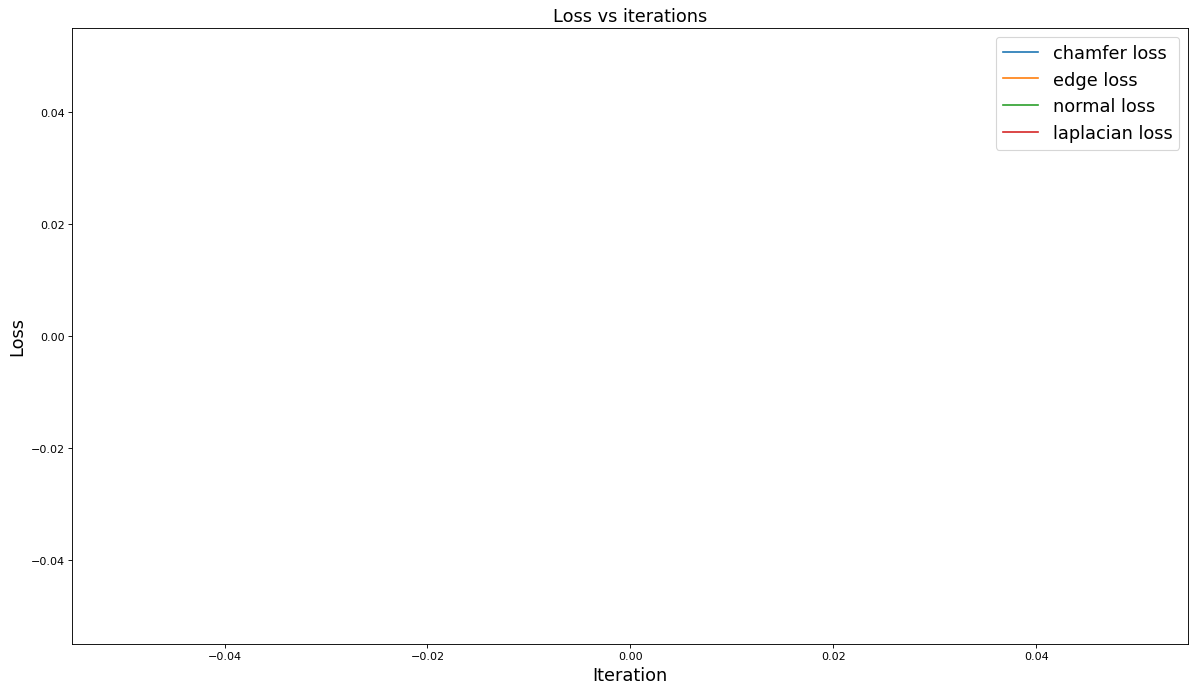

In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale.to(device) + center.to(device)
final_obj = os.path.join('./', 'opt_mug.obj')
save_obj(final_obj, final_verts, final_faces)

Check: https://hallpaz.github.io/3dsystems20/assignment1.html

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.Adam([deform_verts], lr=1.0)

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


  0%|          | 0/5000 [00:00<?, ?it/s]

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

TypeError: ignored

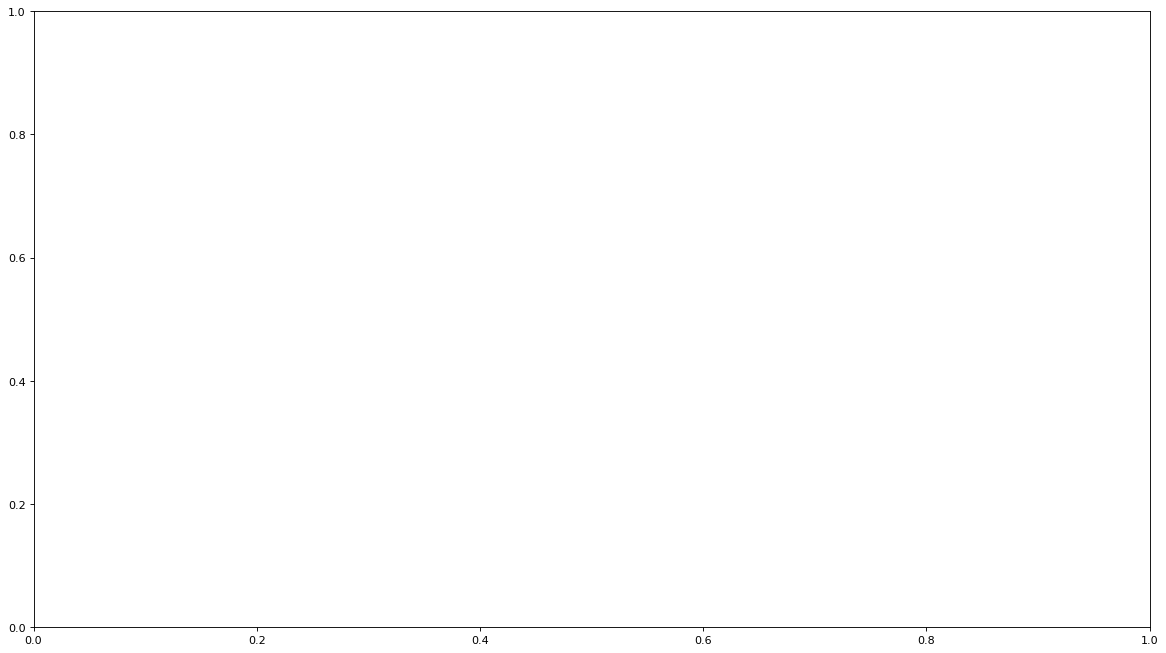

In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.RMSprop([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

In [ ]:
plot_pointcloud(trg_mesh)

In [ ]:
plot_pointcloud(new_src_mesh)

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.Adam([deform_verts])

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale.to(device) + center.to(device)
final_obj = os.path.join('./', 'dolphin_adam.obj')
save_obj(final_obj, final_verts, final_faces)

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(torus_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
# Number of optimization steps
Niter = 5000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.10
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = torus_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(mug_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh after each `plot_period` iterations
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses}
plot_losses(losses, (18, 10))

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale.to(device) + center.to(device)
final_obj = os.path.join('./', 'opt_mugn01.obj')
save_obj(final_obj, final_verts, final_faces)